In [232]:
from coactivation.process import preprocess_emgs, get_coactivation_map, get_coactivation_difference, get_all_healthy_map, get_coactivation_bool_map, get_alignment_map, array_to_cm,generate_coactivation_csv, mirror_left_right,emgs
from coactivation.visualize import visualize_emgs, plot_coactivation_corr, plot_coactivation_map, plot_bool_map, plot_alignment_map

import pandas as pd
import numpy as np

from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from matplotlib.colors import LinearSegmentedColormap

In [233]:
# generate_coactivation_csv()

# Preprocessing

In [234]:
df_raw = pd.read_csv('coactivations.csv', index_col=0)

In [235]:
df = df_raw[(df_raw.subject_id!='Augmen')]

In [236]:
df

,gt0emg0,gt0emg1,gt0emg2,gt0emg3,gt0emg4,gt0emg5,gt0emg6,gt0emg7,gt1emg0,gt1emg1,...,gt2emg2,gt2emg3,gt2emg4,gt2emg5,gt2emg6,gt2emg7,hand,is_patient,subject_id,n
0,0.018537,0.020488,0.020488,0.020488,0.021463,0.019512,0.018537,0.018537,0.026341,0.031220,...,0.074146,0.212683,0.175610,0.204878,0.191220,0.067317,left,False,fa,11
0,0.017479,0.019319,0.019319,0.018399,0.019319,0.017479,0.016559,0.017479,0.023919,0.027599,...,0.060718,0.148114,0.121435,0.101196,0.178473,0.087397,left,False,fa,11
0,0.015773,0.018139,0.021293,0.030757,0.033912,0.026025,0.017350,0.015773,0.018927,0.022871,...,0.067823,0.170347,0.143533,0.124606,0.143533,0.064274,left,False,fa,13
0,0.019231,0.023601,0.027972,0.044580,0.059441,0.043706,0.024476,0.019231,0.023601,0.027972,...,0.081294,0.198427,0.156031,0.128497,0.165210,0.086538,left,False,fa,13
0,0.041379,0.115271,0.056158,0.025616,0.026601,0.026601,0.028571,0.026601,0.073892,0.253202,...,0.141872,0.138916,0.051232,0.032512,0.040394,0.107389,right,False,xw,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.031191,0.056711,0.061437,0.026465,0.032136,0.029301,0.023629,0.022684,0.055766,0.059546,...,0.149338,0.224953,0.067108,0.040643,0.034972,0.058601,right,False,yc,13
0,0.020871,0.023593,0.019964,0.019056,0.018149,0.016334,0.016334,0.016334,0.093466,0.237750,...,0.099819,0.294011,0.058984,0.031760,0.203267,0.087114,right,False,is,11
0,0.022989,0.022031,0.022989,0.057471,0.021073,0.018199,0.017241,0.018199,0.091954,0.235632,...,0.074713,0.269157,0.052682,0.031609,0.290230,0.178161,right,False,is,11
0,0.018700,0.020481,0.028495,0.142476,0.042743,0.031167,0.026714,0.017809,0.033838,0.139804,...,0.089047,0.238646,0.076581,0.041852,0.118433,0.289403,right,False,is,13


## flip left and ae

In [237]:
df = mirror_left_right(df)
df = mirror_left_right(df, 'subject_id', 'ae')

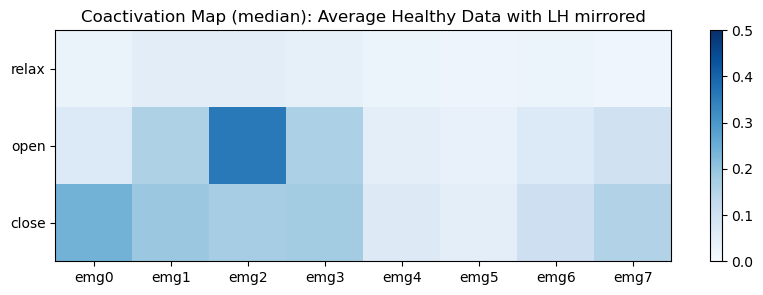

In [238]:
plot_coactivation_map(array_to_cm(df.iloc[:,:24][df.is_patient==False].apply('mean').values), title='Average Healthy Data with LH mirrored')

In [239]:
all_data = df.iloc[:,:24].to_numpy().reshape(1, 121*24)[0]
sum(all_data > 0.5), np.max(df.iloc[:,:24])

(49, 0.704225352112676)

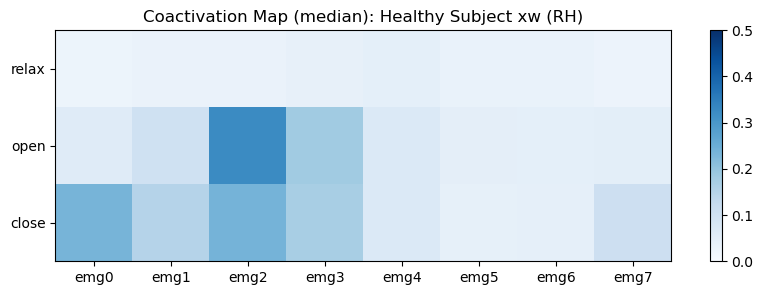

In [240]:
plot_coactivation_map(array_to_cm(df[(df.is_patient==False) & (df.hand=='right')].iloc[3,:24].values).astype(float), title='Healthy Subject xw (RH)')

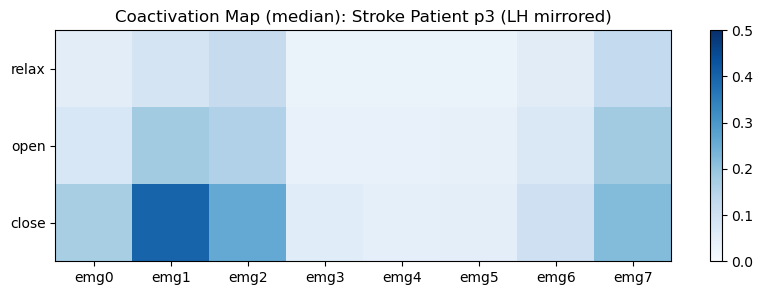

In [241]:
plot_coactivation_map(array_to_cm(df[(df.is_patient==True) & (df.hand=='left')].iloc[3,:24].values).astype(float), title='Stroke Patient p3 (LH mirrored)')


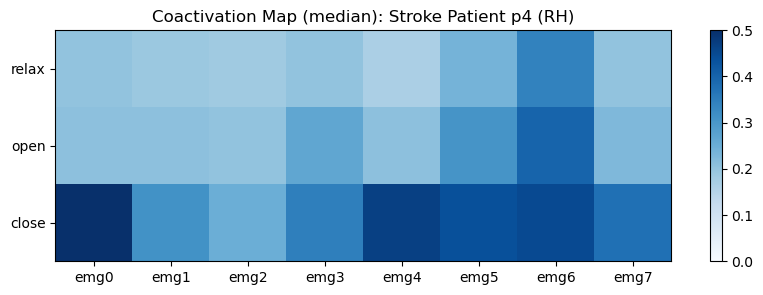

In [242]:
plot_coactivation_map(array_to_cm(df[(df.is_patient==True) & (df.hand=='right')].iloc[3,:24].values).astype(float), title='Stroke Patient p4 (RH)')


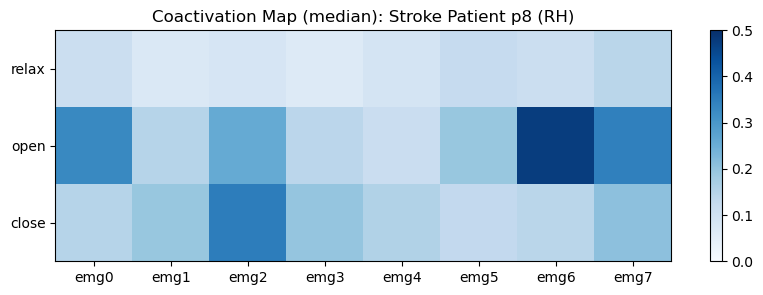

In [243]:
plot_coactivation_map(array_to_cm(df[(df.is_patient==True) & (df.hand=='right')].iloc[19,:24].values).astype(float), title='Stroke Patient p8 (RH)')


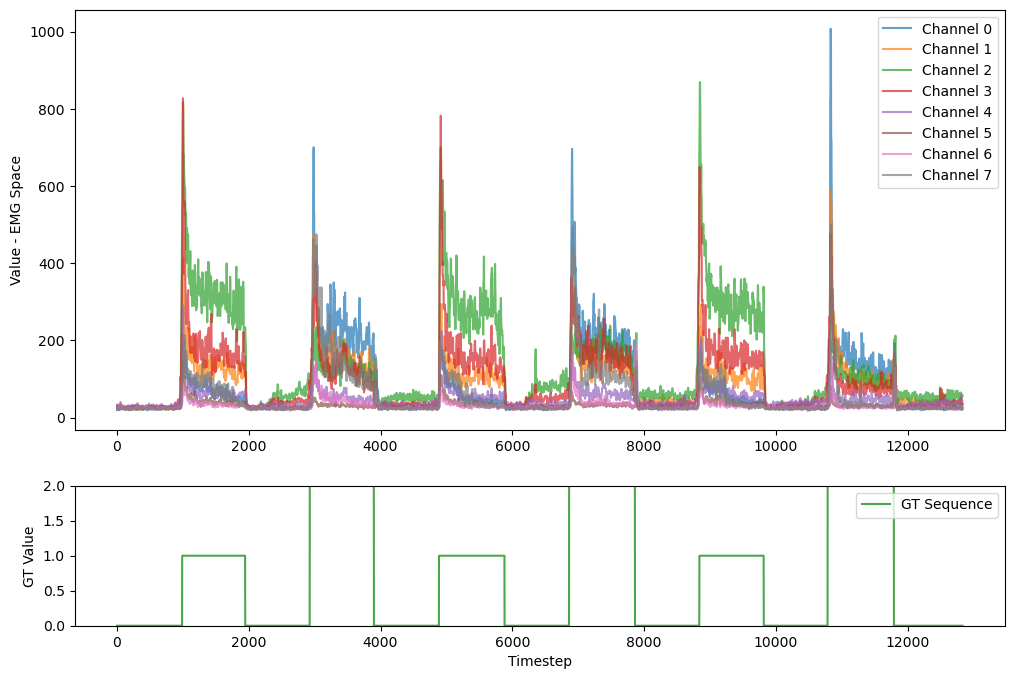

In [244]:
visualize_emgs('collected_data/2023_10_23_xw/xw_131.csv')

# optimal k

## Relax

In [245]:
n_clusters = 4

In [246]:
X = df.iloc[:,:8].values

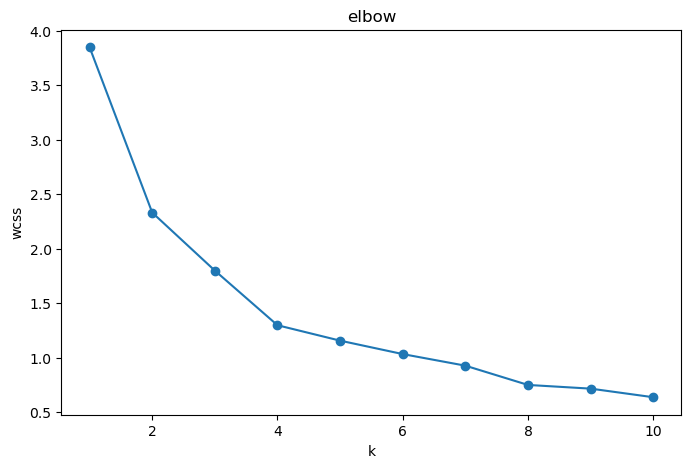

In [247]:
# elbow method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('elbow')
plt.xlabel('k')
plt.ylabel('wcss')
plt.show()

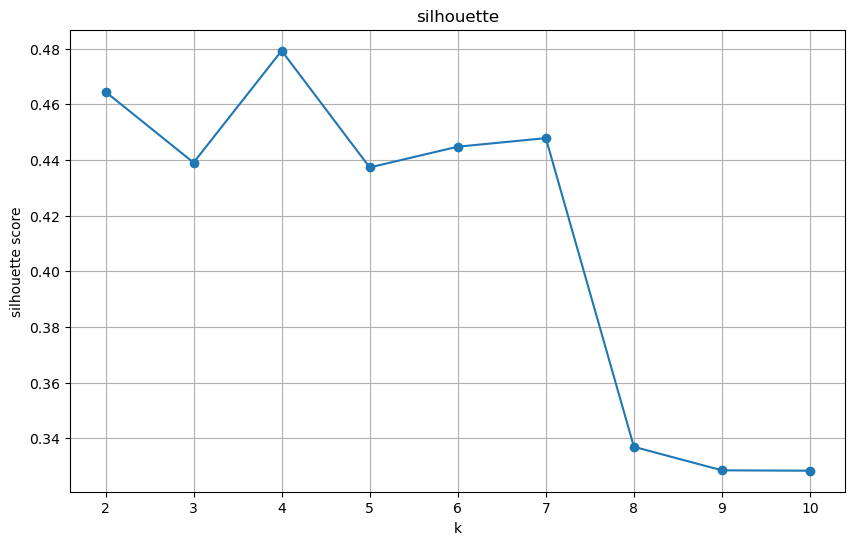

In [248]:
silhouette_scores = []
for k in range(2, 11):  # Silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('silhouette')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

# k-means

In [249]:
kmeans = KMeans(n_clusters=n_clusters,         # Number of clusters
                 init='k-means++',    # Centroid initialization
                 max_iter=300,        # Maximum iterations
                 n_init=10,           # Number of initializations
                 tol=1e-4,    
                 random_state=42,    
                 algorithm='lloyd')
df['cluster'] = kmeans.fit_predict(X)
kmeans.fit(X)

labels = kmeans.predict(X)

print("Cluster Centers:\n", kmeans.cluster_centers_)

Cluster Centers:
 [[0.07380919 0.17331519 0.13053153 0.11127622 0.10419588 0.06331612
  0.05381896 0.06073392]
 [0.03472719 0.04358681 0.04629602 0.03716058 0.02880049 0.02463567
  0.02752337 0.02655664]
 [0.16259985 0.28867532 0.17196026 0.25280054 0.21670516 0.25618176
  0.22283697 0.16081503]
 [0.09502708 0.06569589 0.10893135 0.07079901 0.05669266 0.06202628
  0.22462048 0.15783452]]


In [250]:
def plot_one_class_coactivation_map(coactivation_map, metric='median', title='', label='', cmap='Blues'):
    fig, ax = plt.subplots(figsize=(10,1))
    im = ax.imshow([coactivation_map], cmap=cmap,
                   vmin=0, vmax=0.5)
    ax.set_xticks(np.arange(len(emgs)), labels=emgs)
    ax.set_yticks([0], labels=[label])
    ax.set_title('Coactivation Map (' + metric + '): ' + title)
    fig.colorbar(im, ax=ax)
    return

In [251]:
df['cluster'].value_counts()

cluster
1    74
0    28
3    14
2     5
Name: count, dtype: int64

In [252]:
pd.DataFrame(df.groupby('cluster').apply(lambda x: np.unique(x.subject_id)))

/var/folders/yd/vqpl9gqn5nqfzr41g9_g0t940000gq/T/ipykernel_32655/1772303394.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,0
cluster,
0,"[03, ac, im, p1, p3, p4, p8]"
1,"[03, ae, as, cl, dy, fa, gk, hr, im, is, jo, j..."
2,[p4]
3,"[p3, p7, p8]"


In [253]:
str(pd.DataFrame(df.groupby('cluster').apply(lambda x: np.unique(x.subject_id))).iloc[1].to_numpy()).replace("'","")

/var/folders/yd/vqpl9gqn5nqfzr41g9_g0t940000gq/T/ipykernel_32655/2692373268.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



'[array([03, ae, as, cl, dy, fa, gk, hr, im, is, jo,\n        jp, p1, p3, p4, p8, si, ts, wx, xw, yc],\n       dtype=object)                                                     ]'

In [254]:
tsne_input = df.iloc[:,:24].to_numpy()
data_tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(tsne_input)
data_tsne = pd.DataFrame(data_tsne, columns=['myx', 'myy', 'myz'])
data_tsne['cluster_ids'] = df['cluster'].to_numpy().astype(str)
data_tsne['subject_ids'] = df['subject_id'].to_numpy()


In [281]:
unique_clusters = sorted(data_tsne['cluster_ids'].unique())
# palette = px.colors.qualitative.Plotly 
color_map = {
    "0": "red",   
    "1": "blue",   
    "2": "green",  
    "3": "purple" 
}

# color_map = {str(cluster): palette[i % len(palette)] for i, cluster in enumerate(unique_clusters)}

fig = px.scatter_3d(data_tsne,
                    x='myx', y='myy', z='myz',
                    color='cluster_ids',
                    text='subject_ids',
                    title='Relax: 3D t-SNE for K-means', 
                    color_discrete_map=color_map,
                    category_orders={'cluster_ids': unique_clusters},
)
fig.update_layout(
    legend=dict(
        x=1.15,
        y=0.5, 
        xanchor='left',
        yanchor='middle' 
    )
)

fig.show()
fig.write_html('relax.html')

In [256]:
color_map

{'0': 'red', '1': 'blue', '2': 'green', '3': 'purple'}

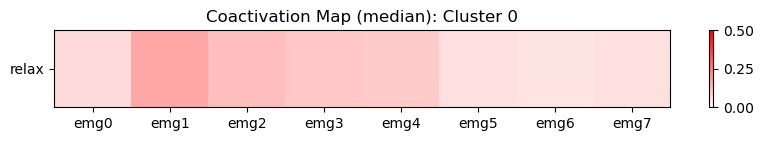

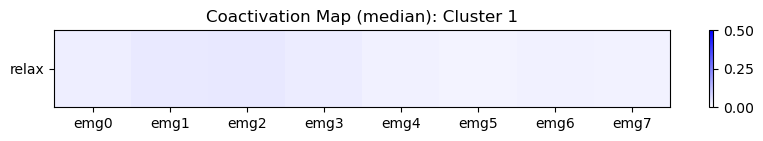

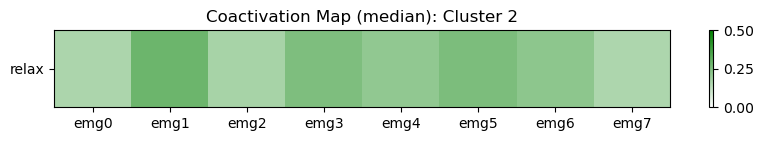

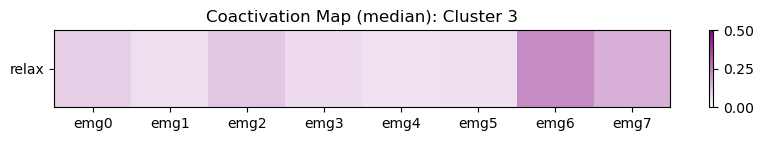

In [257]:
for i in range(len(kmeans.cluster_centers_)):
    cmap = LinearSegmentedColormap.from_list("white_to_color", ["white", color_map[str(i)]])
    cluster_center = kmeans.cluster_centers_[i]
    plot_one_class_coactivation_map(cluster_center, title='Cluster ' + str(i), label='relax', cmap=cmap)

## open

In [259]:
X = df.iloc[:,8:16].values

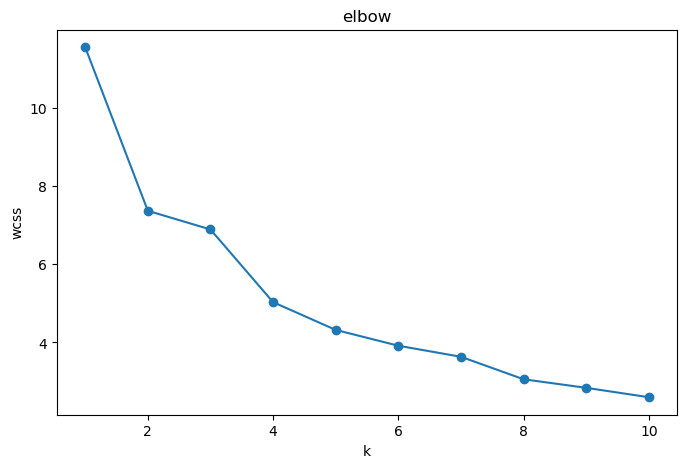

In [260]:
# elbow method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('elbow')
plt.xlabel('k')
plt.ylabel('wcss')
plt.show()

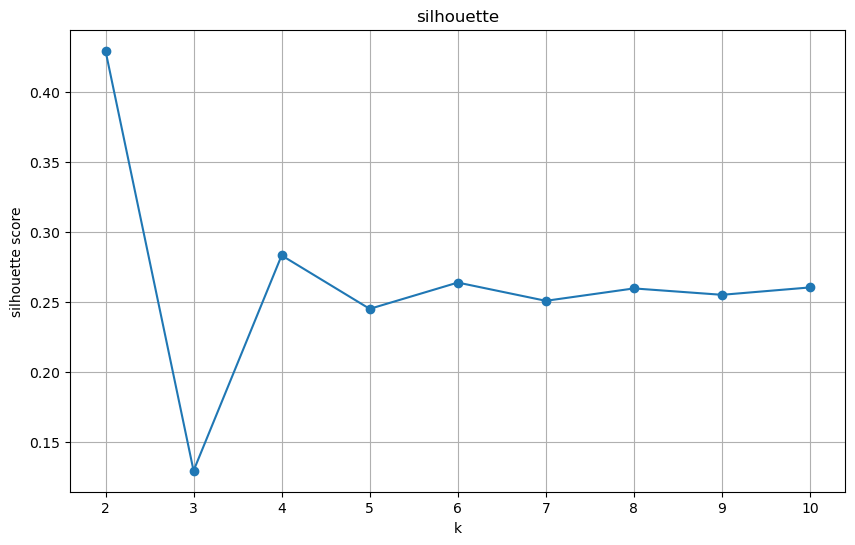

In [261]:
silhouette_scores = []
for k in range(2, 11):  # Silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('silhouette')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

# k-means

In [262]:
kmeans = KMeans(n_clusters=n_clusters,         # Number of clusters
                 init='k-means++',    # Centroid initialization
                 max_iter=300,        # Maximum iterations
                 n_init=10,           # Number of initializations
                 tol=1e-4,    
                 random_state=42,    
                 algorithm='lloyd')
df['cluster'] = kmeans.fit_predict(X)
kmeans.fit(X)

labels = kmeans.predict(X)

print("Cluster Centers:\n", kmeans.cluster_centers_)

Cluster Centers:
 [[0.08272723 0.19069214 0.13559375 0.10350297 0.09251743 0.0567663
  0.05989026 0.07987805]
 [0.12283259 0.14472053 0.49413651 0.23462025 0.06614958 0.05705025
  0.37599075 0.29189873]
 [0.06488916 0.15340132 0.37837165 0.18171942 0.06258249 0.03830004
  0.04124879 0.08279505]
 [0.29317931 0.21394738 0.22092385 0.21164122 0.17482285 0.23813209
  0.39066042 0.28397991]]


In [263]:
df['cluster'].value_counts()

cluster
2    57
0    36
1    15
3    13
Name: count, dtype: int64

In [264]:
pd.DataFrame(df.groupby('cluster').apply(lambda x: np.unique(x.subject_id)))

/var/folders/yd/vqpl9gqn5nqfzr41g9_g0t940000gq/T/ipykernel_32655/1772303394.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,0
cluster,
0,"[03, ae, fa, im, p1, p3, p4, p7]"
1,"[jp, p7, ts]"
2,"[ac, as, cl, dy, gk, hr, im, is, jo, p1, si, w..."
3,"[p4, p8]"


In [265]:
str(pd.DataFrame(df.groupby('cluster').apply(lambda x: np.unique(x.subject_id))).iloc[2].to_numpy()).replace("'","")

/var/folders/yd/vqpl9gqn5nqfzr41g9_g0t940000gq/T/ipykernel_32655/1655693180.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



'[array([ac, as, cl, dy, gk, hr, im, is, jo, p1, si,\n        wx, xw, yc], dtype=object)                                 ]'

In [266]:
tsne_input = df.iloc[:,:24].to_numpy()
data_tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(tsne_input)
data_tsne = pd.DataFrame(data_tsne, columns=['myx', 'myy', 'myz'])
data_tsne['cluster_ids'] = df['cluster'].to_numpy().astype(str)
data_tsne['subject_ids'] = df['subject_id'].to_numpy()


In [267]:
unique_clusters = sorted(data_tsne['cluster_ids'].unique())
# palette = px.colors.qualitative.Plotly 
color_map = {
    "0": "red",   
    "1": "blue",   
    "2": "green",  
    "3": "purple" 
}

# color_map = {str(cluster): palette[i % len(palette)] for i, cluster in enumerate(unique_clusters)}

fig = px.scatter_3d(data_tsne,
                    x='myx', y='myy', z='myz',
                    color='cluster_ids',
                    text='subject_ids',
                    title='Open: 3D t-SNE for K-means', 
                    color_discrete_map=color_map,
                    category_orders={'cluster_ids': unique_clusters},
)
fig.update_layout(
    legend=dict(
        x=1.15,
        y=0.5, 
        xanchor='left',
        yanchor='middle' 
    )
)

fig.show()
fig.write_html('open.html')

In [268]:
# frames = []
# for i in range(0, 360, 1):
#     camera = dict(
#         eye=dict(x=2*np.cos(np.radians(i)), y=2*np.sin(np.radians(i)), z=1.25)
#     )
#     frames.append(go.Frame(layout=dict(scene_camera=camera)))

# fig.frames = frames

# fig.update_layout(
#     updatemenus=[dict(
#         type="buttons",
#         buttons=[dict(
#             label="Play",
#             method="animate",
#             # args=[None, dict(frame=dict(duration=10, redraw=True), fromcurrent=True, transition=dict(duration=0))]
#             args=[None, dict(
#                 frame=dict(duration=5, redraw=False),  # Minimal frame duration, disable redraw
#                 fromcurrent=True,
#                 transition=dict(duration=0),  # No transition delay
#                 easing="linear"  # Keep easing linear for smoothness
#             )]
#         )]
#     )]
# )
# fig.write_html('testtest.html')

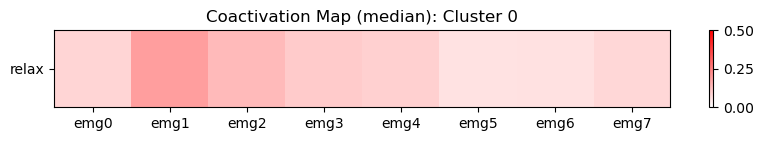

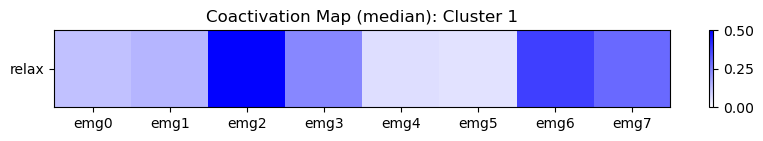

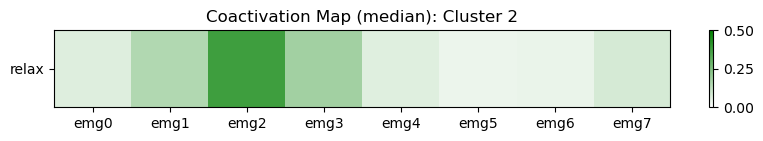

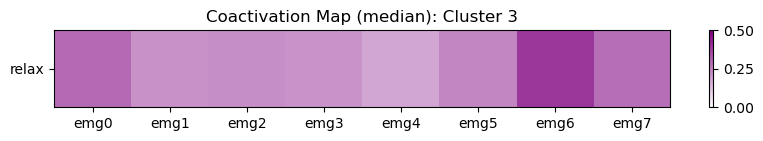

In [269]:
for i in range(len(kmeans.cluster_centers_)):
    cmap = LinearSegmentedColormap.from_list("white_to_color", ["white", color_map[str(i)]])
    cluster_center = kmeans.cluster_centers_[i]
    plot_one_class_coactivation_map(cluster_center, title='Cluster ' + str(i), label='relax', cmap=cmap)

## closed

In [270]:
X = df.iloc[:,16:24].values

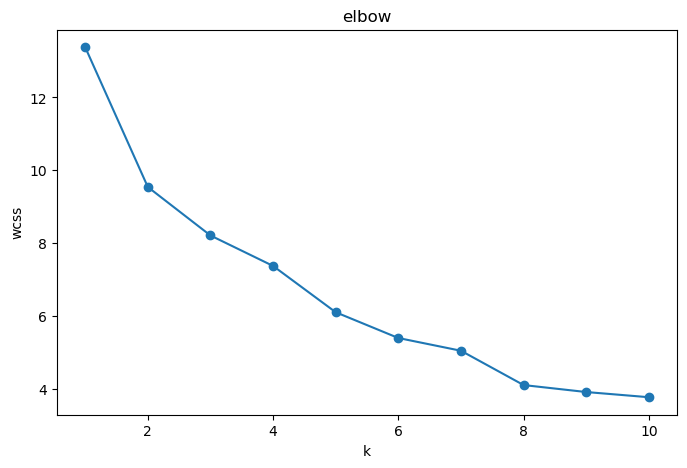

In [271]:
# elbow method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('elbow')
plt.xlabel('k')
plt.ylabel('wcss')
plt.show()

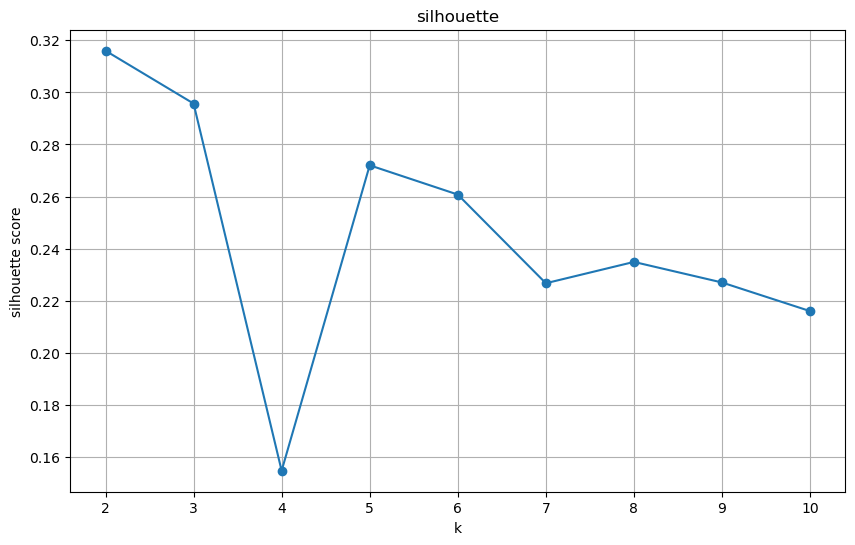

In [272]:
silhouette_scores = []
for k in range(2, 11):  # Silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('silhouette')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

# k-means

In [273]:
kmeans = KMeans(n_clusters=n_clusters,         # Number of clusters
                 init='k-means++',    # Centroid initialization
                 max_iter=300,        # Maximum iterations
                 n_init=10,           # Number of initializations
                 tol=1e-4,    
                 random_state=42,    
                 algorithm='lloyd')
df['cluster'] = kmeans.fit_predict(X)
kmeans.fit(X)

labels = kmeans.predict(X)

print("Cluster Centers:\n", kmeans.cluster_centers_)

Cluster Centers:
 [[0.31098563 0.21420046 0.17507059 0.23175333 0.0696093  0.06021559
  0.23179854 0.32690562]
 [0.34589121 0.50866407 0.21130995 0.3195308  0.35603098 0.29003973
  0.18813244 0.19524467]
 [0.19284018 0.17273224 0.16571914 0.15893589 0.07422318 0.04767719
  0.09160431 0.10432354]
 [0.17903209 0.31576552 0.45512163 0.24312703 0.17934306 0.12542328
  0.15420029 0.2453086 ]]


In [274]:
df['cluster'].value_counts()

cluster
2    65
3    22
0    21
1    13
Name: count, dtype: int64

In [275]:
pd.DataFrame(df.groupby('cluster').apply(lambda x: np.unique(x.subject_id)))

/var/folders/yd/vqpl9gqn5nqfzr41g9_g0t940000gq/T/ipykernel_32655/1772303394.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,0
cluster,
0,"[ac, as, is, jp, p7, ts, wx]"
1,[p4]
2,"[03, ae, as, cl, dy, fa, gk, hr, im, is, jo, j..."
3,"[jo, p1, p3, p7, p8]"


In [276]:
str(pd.DataFrame(df.groupby('cluster').apply(lambda x: np.unique(x.subject_id))).iloc[2].to_numpy()).replace("'","")

/var/folders/yd/vqpl9gqn5nqfzr41g9_g0t940000gq/T/ipykernel_32655/1655693180.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



'[array([03, ae, as, cl, dy, fa, gk, hr, im, is, jo,\n        jp, p1, p3, p4, p7, p8, si, xw, yc], dtype=object)]'

In [277]:
tsne_input = df.iloc[:,:24].to_numpy()
data_tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(tsne_input)
data_tsne = pd.DataFrame(data_tsne, columns=['myx', 'myy', 'myz'])
data_tsne['cluster_ids'] = df['cluster'].to_numpy().astype(str)
data_tsne['subject_ids'] = df['subject_id'].to_numpy()


In [278]:
unique_clusters = sorted(data_tsne['cluster_ids'].unique())
# palette = px.colors.qualitative.Plotly 
color_map = {
    "0": "red",   
    "1": "blue",   
    "2": "green",  
    "3": "purple" 
}

# color_map = {str(cluster): palette[i % len(palette)] for i, cluster in enumerate(unique_clusters)}

fig = px.scatter_3d(data_tsne,
                    x='myx', y='myy', z='myz',
                    color='cluster_ids',
                    text='subject_ids',
                    title='Close: 3D t-SNE for K-means', 
                    color_discrete_map=color_map,
                    category_orders={'cluster_ids': unique_clusters},
)
fig.update_layout(
    legend=dict(
        x=1.15,
        y=0.5, 
        xanchor='left',
        yanchor='middle' 
    )
)

fig.show()
fig.write_html('close.html')

In [279]:
# frames = []
# for i in range(0, 360, 1):
#     camera = dict(
#         eye=dict(x=2*np.cos(np.radians(i)), y=2*np.sin(np.radians(i)), z=1.25)
#     )
#     frames.append(go.Frame(layout=dict(scene_camera=camera)))

# fig.frames = frames

# fig.update_layout(
#     updatemenus=[dict(
#         type="buttons",
#         buttons=[dict(
#             label="Play",
#             method="animate",
#             # args=[None, dict(frame=dict(duration=10, redraw=True), fromcurrent=True, transition=dict(duration=0))]
#             args=[None, dict(
#                 frame=dict(duration=5, redraw=False),  # Minimal frame duration, disable redraw
#                 fromcurrent=True,
#                 transition=dict(duration=0),  # No transition delay
#                 easing="linear"  # Keep easing linear for smoothness
#             )]
#         )]
#     )]
# )
# fig.write_html('testtest.html')

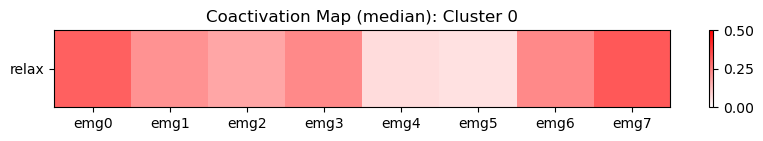

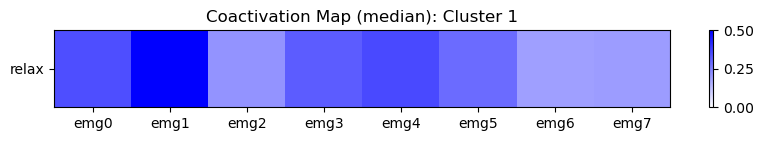

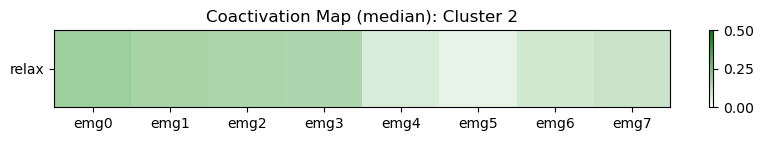

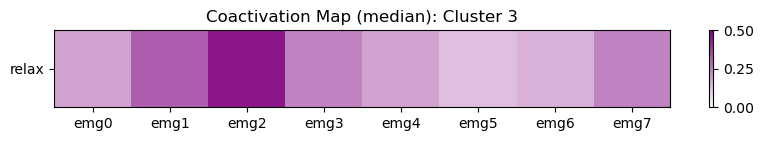

In [280]:
for i in range(len(kmeans.cluster_centers_)):
    cmap = LinearSegmentedColormap.from_list("white_to_color", ["white", color_map[str(i)]])
    cluster_center = kmeans.cluster_centers_[i]
    plot_one_class_coactivation_map(cluster_center, title='Cluster ' + str(i), label='relax', cmap=cmap)